In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Covariance

In [2]:
def exponential_cov(x, y, params):
    # kernel
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x, y)**2)

def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return (mu.squeeze(), sigma.squeeze())

cov of 0 and 0: 1.0


<ErrorbarContainer object of 3 artists>

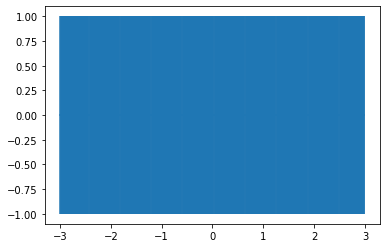

In [3]:
theta = [1, 10]  # params
theta_0 = exponential_cov(0, 0, theta)
print("cov of 0 and 0:", theta_0)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=theta_0, capsize=0)

In [5]:
x = [1.]
y = [np.random.normal(scale=theta_0)]
y

[-0.9523416546614363]

In [6]:
theta_1 = exponential_cov(x, x, theta)
 
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new
 
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, theta_1, y) for i in x_pred]

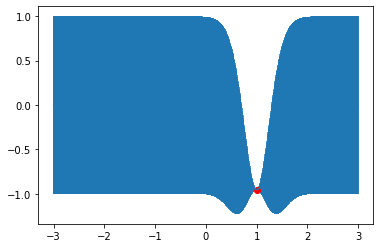

In [7]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [48]:
m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
y2

-1.057547972950803

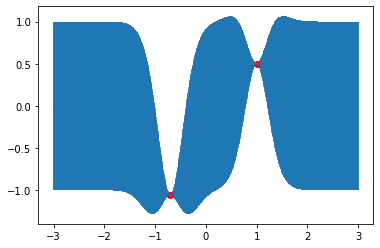

In [49]:
x.append(-0.7)
y.append(y2)
 
theta_2 = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, theta_2, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [40]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-0.89530762, -1.07348478,  1.28060113, -0.42567031, -1.30061975])

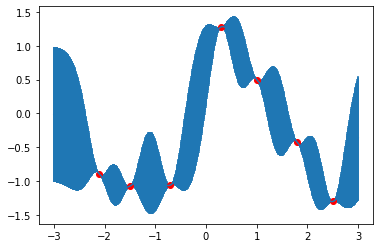

In [50]:
x += x_more
y += y_more.tolist()
 
theta_new = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, theta_new, y) for i in x_pred]
 
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

/Users/jeremy.zhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


(-10.577494824415874,
 10.207749851457285,
 -46.45728555959633,
 39.04140469387481)

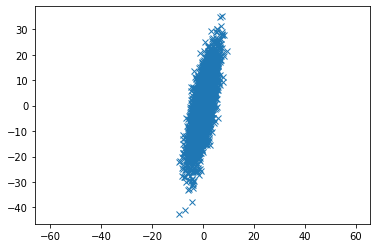

In [70]:
mean = [0, 0]
cov = [[1, 20], [20, 100]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 5000).T

plt.plot(x, y, 'x')
plt.axis('equal')

In [71]:
from scipy.stats import multivariate_normal

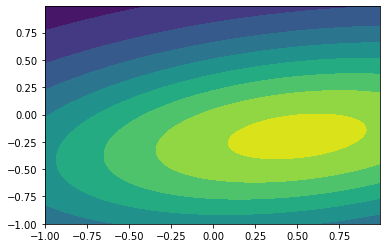

In [73]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

plt.contourf(x, y, rv.pdf(pos))

In [79]:
rv.pdf([0.6, -0.2])

0.16638199169788842

### GP2

In [50]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    plt.figure(figsize=[10, 4])
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [51]:
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

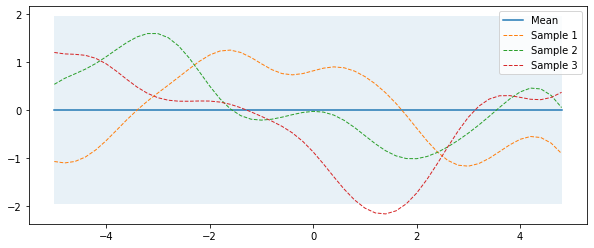

In [52]:
plot_gp(mu, cov, X, samples=samples)

In [44]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [61]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

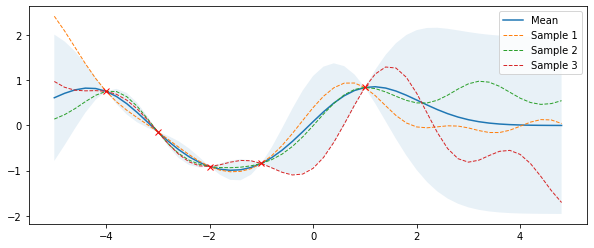

In [64]:
plot_gp(mu_s, cov_s, X, X_train, Y_train, samples=samples)

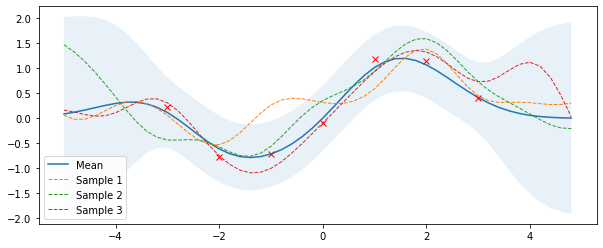

In [57]:
# add noise
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [65]:
noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))


mu_s, cov_s = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)


In [69]:
cov_s.shape

(1156, 1156)

In [70]:
Y_2D_train.shape

(100,)

In [71]:
X_2D.shape

(1156, 2)